In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import cv2
from glob import glob

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.set_random_seed(1)

In [104]:
from keras.layers import Layer
import os
from keras.datasets import mnist

## Constant variable

In [27]:
IMG_TRAIN_DIR = ''
IMG_TEST_DIR = ''
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
YOLOV3_WEIGHT = 'yolov3.weights'
YOLOV3_CFG = "yolov3.cfg"
COCO_CLASS = 'coco_classes.txt'
CROP_DIR = 'Bottle_crops/'
IMG_DIR = 'Liquor_dataset/'

## Object Detection

In [5]:
net = cv2.dnn.readNet(YOLOV3_WEIGHT, YOLOV3_CFG)
classes = []

with open(COCO_CLASS, "r") as file:
    classes = [cl.strip() for cl in file.readlines()]
# classes

In [6]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [57]:
if not os.path.exists(CROP_DIR):
    os.mkdir(CROP_DIR)

In [97]:
def detect_bottle(image_path):
    image = cv2.imread(image_path)
    img_file_name = image_path.split("/")[-1]
    img_dir_name = image_path.split("/")[-2]
    height, width, channels = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (320, 320), (0,0,0), True, crop=False)
    
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > 0.3:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)
                
                x = int(center_x - w/2)
                y = int(center_y - h/2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.6)
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            if x < 0 or y < 0:
                continue
            
            if (label == "bottle"):
                img_class = CROP_DIR + img_dir_name
                if not os.path.exists(img_class):
                    os.mkdir(img_class)
                    
                cv2.imwrite(img_class+'/'+img_file_name, image[y:y+h, x:x+w])
                confidence = confidences[i]
                color = colors[class_ids[i]]
                cv2.rectangle(image, (x, y), (x+w,y+h), color, 2)
                cv2.putText(image, label + " " + str(round(confidence, 2)), (x,y + 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
    plt.imshow(image)

In [98]:
list_subdir = os.listdir(IMG_DIR)
list_subdir

['.DS_Store',
 'Chivas Regal',
 'Jameson',
 'Smirnoff',
 'Remy Martin',
 'Hennessy',
 'Jack Daniel']

In [99]:
image_paths = []

for subdir in list_subdir:
    image_paths.extend(glob(IMG_DIR + subdir + '/*.jpg'))
len(image_paths)

229

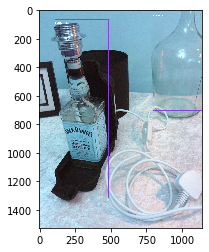

In [103]:
import time

for img_path in image_paths:
    time_start = time.time()
    detect_bottle(img_path)
#     print(time.time() - time_start)

# Image extractor with triplet loss

## Constant variables

In [101]:
TRAIN_DIR = 'Bottle_crops/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)

## Build DataGenerator

In [ ]:
class ImageGenerator:
    def __init__(self):
        self.input_shape = INPUT_SHAPE
        self.train_dir = TRAIN_DIR
        
    def build_dataset(self):
        

## Build triplet loss function 

In [102]:
class TripletlossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletlossLayer, self).__init__(**kwargs)
        
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor - positive), axis=-1)
        n_dist = K.sum(K.square(anchor - negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss